In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier  
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import SCORERS
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('KS_train_data.csv', delimiter=',')
df_test = pd.read_csv('KS_test_data.csv', delimiter=';')
# X = df.loc[:,'f1':'f100'].values
# y = [ bool(y) for y in df.loc[:,'loss'].values ]
df_test[df_test.isnull().any(1)]


,project_id,blurb,category,country,created_at,currency,deadline,fx_rate,goal,launched_at,name,staff_pick,location,subcategory,project_url,reward_url
4938,KS_104938,NaN,art,US,1509679461,USD,1515800048,1.000000,40000.0,1510616048,awlsies,False,"Los Angeles, CA",digital art,https://www.kickstarter.com/projects/145490711...,https://www.kickstarter.com/projects/145490711...
5128,KS_105128,Wildlife Art to empower disadvantaged children...,art,NaN,1476524391,EUR,1479305419,1.245664,2500.0,1476709819,ArtConnects Etosha,True,"Windhoek, Namibia",painting,https://www.kickstarter.com/projects/701001795...,https://www.kickstarter.com/projects/701001795...
16081,KS_116081,"Create a treehouse as an undisturbed, protecte...",design,NaN,1440609127,EUR,1449650435,1.245664,21500.0,1447317635,Treehouse Namibia - Baumhaus Namibia,False,"Okahandja, Namibia",architecture,https://www.kickstarter.com/projects/102468866...,https://www.kickstarter.com/projects/102468866...
21538,KS_121538,"Own a pair of the original bushman San-dals, d...",fashion,NaN,1462284723,GBP,1465461297,1.401112,70000.0,1462869297,THE ORIGINAL SAN-DAL,True,"Tsumkwe, Namibia",footwear,https://www.kickstarter.com/projects/vivobaref...,https://www.kickstarter.com/projects/vivobaref...
58859,KS_158859,BRASIL is a photography book that captures the...,photography,NaN,1437830095,USD,1445896740,1.000000,17000.0,1443258097,BRASIL a photobook,False,"Windhoek, Namibia",photobooks,https://www.kickstarter.com/projects/kristinca...,https://www.kickstarter.com/projects/kristinca...


In [3]:
df.country = df.country.fillna('NA')
df_test.country = df_test.country.fillna('NA')
EU = ('GB', 'ES', 'FR', 'IT', 'NL', 'IS', 'CZ', 'FI', 'DE', 'IE', 'SJ', 'DK', 'SE', 'HU', 'NO', 'CY', 'CH', 'BE', 
          'LV', 'UA', 'AT', 'SI', 'LT', 'RO', 'RU', 'AX', 'MC', 'PT', 'GL', 'GR', 'SK', 'EE', 'BA', 'ME', 'LU', 'RS',
         'PL', 'MD', 'BG', 'HR', 'MK', 'BY', 'XK', 'FO', 'MT')
NA = ('US', 'CA', 'MX', 'CR', 'GT', 'HT', 'AG', 'JM', 'BZ', 'CU', 'SV', 'PR', 'PA', 'NI', 'DO', 'CW', 'VI', 'BB',
         'HN', 'LC', 'TT', 'BS', 'GP', 'VC', 'DM')
SA = ('AR', 'PE', 'SR', 'BR', 'BO', 'EC', 'CO', 'CL', 'VE', 'PY', 'GY', 'UY')
AF = ('KE', 'MW', 'ZA', 'RW', 'LR', 'EG', 'SN', 'NG', 'TZ', 'GH', 'GQ', 'ZM', 'MG', 'ET', 'MA', 'CD', 'BF', 'UG',
         'CI', 'DZ', 'ML', 'SD', 'ZW', 'CM', 'TN', 'NE', 'MZ', 'GN', 'SO', 'LY', 'DJ', 'GA', 'SS', 'GM', 'BJ', 'CF',
          'CG', 'NA')
AS = ('TH', 'ID', 'KH', 'IN', 'JP', 'TR', 'CN', 'MY', 'MN', 'IL', 'KR', 'PH', 'HK', 'SG', 'PS', 'TW', 'NP', 'IR',
         'QA', 'VN', 'IQ', 'AE', 'LK', 'GE', 'LB', 'AM', 'KZ', 'AF', 'KP', 'BD', 'PK', 'MM', 'BT', 'JO', 'MV', 'LA',
         'KW', 'SY', 'TJ', 'TL', 'YE', 'MO', 'KG')
AT = ('AQ')
OC = ('AU','NZ', 'PG', 'FJ', 'FM', 'CK', 'GU', 'NC', 'PF', 'VU' )
UNK = ('?')
def conditions(x):
    if x in EU:
        return "EU"
    elif x in NA:
        return "NA"
    elif x in SA:
        return "SA"
    elif x in AF:
        return "AF"
    elif x in AS:
        return "AS"
    elif x in AT:
        return "AT"
    elif x in OC:
        return "OC"
    else:
        return "UNK"

func = np.vectorize(conditions)
continents = func(df["country"])
df["continent"] = continents

continents = func(df_test['country'])
df_test["continent"] = continents
df_test.continent.unique()

array(['NA', 'SA', 'EU', 'AF', 'OC', 'AS', 'UNK', 'AT'], dtype=object)

In [4]:
total_in_cat = {}
funded_in_cat = {}
rate_funded_cat = {}
for x in df.category.unique():
    total_in_cat[x] = df.loc[(df.category == x, 'project_id')].count()
    funded_in_cat[x] = df.loc[(df.category == x) & (df.funded == True), 'project_id'].count() 
    rate_funded_cat[x] = funded_in_cat[x] / total_in_cat[x]
df['rate_funded_cat'] = df.apply(lambda row: rate_funded_cat[row.category], axis=1)
df_test['rate_funded_cat'] = df_test.apply(lambda row: rate_funded_cat[row.category], axis=1)

In [5]:
total_in_country = {}
funded_in_country = {}
rate_funded_country = {}
for x in df.country.unique():
    total_in_country[x] = df.loc[(df.country == x, 'project_id')].count()
    funded_in_country[x] = df.loc[(df.country == x) & (df.funded == True), 'project_id'].count() 
    rate_funded_country[x] = funded_in_country[x] / total_in_country[x]
df['rate_funded_country'] = df.apply(lambda row: rate_funded_country[row.country], axis=1)
df_test['rate_funded_country'] = df.apply(lambda row: rate_funded_country[row.country], axis=1)


In [6]:
total_in_continent = {}
funded_in_continent = {}
rate_funded_continent = {}
for x in df.continent.unique():
    total_in_continent[x] = df.loc[(df.continent == x, 'project_id')].count()
    funded_in_continent[x] = df.loc[(df.continent == x) & (df.funded == True), 'project_id'].count() 
    rate_funded_continent[x] = funded_in_continent[x] / total_in_continent[x]
df['rate_funded_continent'] = df.apply(lambda row: rate_funded_continent[row.continent], axis=1)
df_test['rate_funded_continent'] = df.apply(lambda row: rate_funded_continent[row.continent], axis=1)

In [7]:
total_in_sub = {}
funded_in_sub = {}
rate_funded_sub = {}
for x in df.subcategory.unique():
    total_in_sub[x] = df.loc[(df.subcategory == x, 'project_id')].count()
    funded_in_sub[x] = df.loc[(df.subcategory == x) & (df.funded == True), 'project_id'].count() 
    rate_funded_sub[x] = funded_in_sub[x] / total_in_sub[x]
df['rate_funded_sub'] = df.apply(lambda row: rate_funded_sub[row.subcategory], axis=1)
df_test['rate_funded_sub'] = df.apply(lambda row: rate_funded_sub[row.subcategory], axis=1)

In [8]:
df['delta_time_created'] = df.deadline - df.created_at
df['delta_time_launched'] = df.deadline - df.launched_at
df['delta_time_launched_days'] = df.delta_time_launched / 86400
df['delta_time_created_days'] = df.delta_time_launched / 86400
df['goal_converted_log'] = np.log(df.goal * df.fx_rate)
df['goal_per_day'] = df['goal_converted_log'] / df['delta_time_launched']

df_test['delta_time_created'] = df_test.deadline - df.created_at
df_test['delta_time_launched'] = df_test.deadline - df.launched_at
df_test['delta_time_launched_days'] = df_test.delta_time_launched / 86400
df_test['delta_time_created_days'] = df_test.delta_time_launched / 86400
df_test['goal_converted_log'] = np.log(df.goal * df_test.fx_rate)
df_test['goal_per_day'] = df_test['goal_converted_log'] / df_test['delta_time_launched']
cols = ['rate_funded_sub','rate_funded_continent', 'rate_funded_cat', 
        'delta_time_launched_days', 'goal_converted_log', 'staff_pick', 'delta_time_created_days', 'launched_at']

In [ ]:
new_df = df
new_df_test = df_test

from sklearn.feature_extraction.text import CountVectorizer
import scipy as sp

vectorizer = CountVectorizer()
vectorizer.max_features = 500
vectorizer.max_df = .5

X = vectorizer.fit_transform(new_df.name.astype('U')) 
count_vect_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())
new_df = pd.concat([new_df, count_vect_df], axis=1)
new_df_test = pd.concat([new_df_test, count_vect_df], axis=1)
print(new_df_test.columns)
cols

In [ ]:
for word in vectorizer.get_feature_names():
    cols.append(word)


In [9]:
X = df[cols]
y = df['funded']

X_test_data = df_test[cols]

In [30]:
def contigency_matrix(true_y, predicted_y):
    # YOUR CODE HERE, Create TP, FP, TN, FN
    tp=fp=tn=fn=0
    for true, pred in zip(true_y, predicted_y):
        if pred == True:
            if pred == true:
                tp += 1
            else:
                fp += 1
        else:
            if pred == true:
                tn += 1
            else:
                fn += 1      
    matrix = np.array(([tp, fp], [tn, fn]))
    # Make sure your output fits the following format:
    # matrix = np.array(([TP, FP], [TN, FN]))
    return matrix

def accuracy(true_y, predicted_y):
    matrix = contigency_matrix(true_y, predicted_y)
    tp = matrix[0][0]
    fp = matrix[0][1]
    tn = matrix[1][0]
    fn = matrix[1][1]
    if tp+fp+fn+tn == 0:
        return 0
    else:
        accuracy = (tp+tn)/(tp+fp+fn+tn)
        return accuracy
def precision(true_y, predicted_y):
    matrix = contigency_matrix(true_y, predicted_y)
    tp = matrix[0][0]
    fp = matrix[0][1]
    tn = matrix[1][0]
    fn = matrix[1][1]
    if tp+fp == 0:
        return 0
    else:
        precision = tp/(tp+fp)
        return precision
def recall(true_y, predicted_y):
    matrix = contigency_matrix(true_y, predicted_y)
    tp = matrix[0][0]
    fp = matrix[0][1]
    tn = matrix[1][0]
    fn = matrix[1][1]
    if tp+fn == 0:
        return 0
    else:
        recall = tp/(tp+fn)
        return recall
def f1(true_y, predicted_y):
    precision_v = precision(true_y, predicted_y)
    recall_v = recall(true_y, predicted_y)
    if precision_v+recall_v == 0:
        return 0
    else:
        f1 = 2*((precision_v*recall_v)/(precision_v+recall_v))
        return f1

In [ ]:
def polynomial(X, degree):
    
    ### BEGIN SOLUTION
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    ### END SOLUTION
    return X_poly

In [31]:
y = np.array(y)
y = y.reshape(-1,1)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25)
imp_median_X = SimpleImputer(missing_values=np.nan, strategy='median').fit(X_train)
X_train = imp_median_X.transform(X_train)
X_test = imp_median_X.transform(X_test)

imp_median_y = SimpleImputer(missing_values=np.nan, strategy='median').fit(y_train)
y_train = imp_median_y.transform(y_train)
y_test = imp_median_y.transform(y_test)

# fit scaler and scale features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)

    
def compute_scores(X_train,X_test,y_train,y_test, C):
    # fit logistic regression model
    logreg = LogisticRegression(C=C, solver='liblinear').fit(X_train,y_train.ravel())
    # predict y for train set
    pred_train = logreg.predict(X_train).tolist()
    # predict y for test set
    pred_test = logreg.predict(X_test).tolist()
            
    # calculate evaluation measures
    evaluation_measures = dict()
    evaluation_measures['accuracy_train'] = accuracy(y_train, pred_train)
    evaluation_measures['accuracy_test'] = accuracy(y_test, pred_test)
    
    evaluation_measures['precision_train'] = precision(y_train, pred_train)
    evaluation_measures['precision_test'] = precision(y_test, pred_test)
    
    evaluation_measures['recall_train'] = recall(y_train, pred_train)
    evaluation_measures['recall_test'] = recall(y_test, pred_test)
    
    evaluation_measures['f1_train'] = f1(y_train, pred_train)
    evaluation_measures['f1_test'] = f1(y_test, pred_test)
    
    return evaluation_measures

# for power in [1, 2]:
#     X_train_poly = polynomial(X_train, power)
#     X_test_poly = polynomial(X_test, power)
# # Scale all features using the RobustScaler
# scaler = RobustScaler().fit(X_train_poly)
# X_train_scaled = scaler.transform(X_train_poly)
# X_test_scaled = scaler.transform(X_test_poly)
C = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3, 1e4]
measures = pd.DataFrame()
for c in C:
    em = compute_scores(X_train_scaled,X_test_scaled,y_train,y_test, c)
    em = pd.Series(em)
    measures = measures.append(em, ignore_index=True)
measures.index = C
measures.index = measures.index.rename('C-value')
display(measures)

,accuracy_test,accuracy_train,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
C-value,,,,,,,,
0.0001,0.78036,0.775947,0.808723,0.804646,0.822679,0.820830,0.795232,0.789087
0.0010,0.78908,0.784880,0.818053,0.814807,0.824110,0.820401,0.812085,0.809289
0.0100,0.78840,0.784747,0.817888,0.815206,0.822019,0.818504,0.813797,0.811934
0.1000,0.78836,0.784707,0.817847,0.815216,0.822007,0.818315,0.813729,0.812139
1.0000,0.78840,0.784720,0.817900,0.815234,0.821975,0.818305,0.813866,0.812185
10.0000,0.78840,0.784707,0.817900,0.815220,0.821975,0.818301,0.813866,0.812162
100.0000,0.78840,0.784680,0.817900,0.815197,0.821975,0.818278,0.813866,0.812139
1000.0000,0.78840,0.784680,0.817900,0.815197,0.821975,0.818278,0.813866,0.812139
10000.0000,0.78840,0.784680,0.817900,0.815197,0.821975,0.818278,0.813866,0.812139


In [16]:
logreg = LogisticRegression(C=1, solver='liblinear').fit(X_train,y_train.ravel())
pred_train = logreg.predict(X_train).tolist()
contigency_matrix(y_train, pred_train)

array([[36098,  7453],
       [23642,  7807]])

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)
transformer = RobustScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
X_testdata_transformed = transformer.transform(X_test_data)

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(14, 8), random_state=1)
clf.fit(X_train, y_train)
print(f'Training accuracy: {clf.score(X_train, y_train)}')
print(f'Testing accuracy: {clf.score(X_test, y_test)}')

Training accuracy: 0.8015
Testing accuracy: 0.8030333333333334


In [48]:
clf.predict(X_testdata_transformed)

array([False,  True, False, ...,  True,  True, False])

In [49]:
df_test['prediction'] = clf.predict(X_testdata_transformed).astype(int)

In [50]:
df_save = df_test[['project_id','prediction']]

In [51]:
df_save.to_csv('predictions.tsv', sep='\t', columns=['project_id','prediction'])

In [52]:
df_save.loc[df_save.prediction == 1]

,project_id,prediction
1,KS_100001,1
3,KS_100003,1
4,KS_100004,1
5,KS_100005,1
6,KS_100006,1
...,...,...
78057,KS_178057,1
78058,KS_178058,1
78061,KS_178061,1
78062,KS_178062,1


In [34]:
cols

['rate_funded_sub',
 'rate_funded_continent',
 'rate_funded_cat',
 'delta_time_launched_days',
 'goal_converted_log',
 'staff_pick']

In [53]:
df_test

,project_id,blurb,category,country,created_at,currency,deadline,fx_rate,goal,launched_at,...,rate_funded_country,rate_funded_continent,rate_funded_sub,delta_time_created,delta_time_launched,delta_time_launched_days,delta_time_created_days,goal_converted_log,goal_per_day,prediction
0,KS_100000,We are looking to bring a Visiting Sculptor fr...,art,US,1330727362,USD,1334959598,1.0,3900.0,1332972398,...,0.608791,0.602472,0.451417,8979093.0,1990338.0,23.036319,23.036319,7.937375,3.987953e-06,0
1,KS_100001,Surrealistic oil paintings capturing the metam...,art,US,1332598567,USD,1334635140,1.0,750.0,1332975679,...,0.608791,0.602472,0.679271,3709056.0,1650995.0,19.108738,19.108738,8.411833,5.095008e-06,1
2,KS_100002,P.M.A.F.T.W. my upcoming solo show June 2012 a...,art,US,1332476607,USD,1333421843,1.0,1000.0,1332989843,...,0.608791,0.602472,0.481656,1038949.0,430104.0,4.978056,4.978056,8.517193,1.980264e-05,0
3,KS_100003,A series of images about the art/artist and lo...,art,US,1327538509,USD,1338231398,1.0,15000.0,1333047398,...,0.541360,0.494152,1.000000,5888947.0,5239702.0,60.644699,60.644699,8.779557,1.675583e-06,1
4,KS_100004,Become a part of the first crowd-funded commun...,art,US,1332705528,USD,1334606400,1.0,4200.0,1333049586,...,0.608791,0.602472,0.679271,6043783.0,1614160.0,18.682407,18.682407,9.615805,5.957158e-06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78060,KS_178060,Your opportunity to help improvMANIA open Chan...,theater,US,1405399445,USD,1410324720,1.0,7900.0,1407784586,...,0.608791,0.602472,0.614325,7551465.0,6123249.0,70.870937,70.870937,9.975808,1.629169e-06,0
78061,KS_178061,Dad's Garage Theatre Company needs your help b...,theater,US,1409848035,USD,1415722236,1.0,116000.0,1410534636,...,0.608791,0.602472,0.614325,13659097.0,11470272.0,132.757778,132.757778,8.517193,7.425450e-07,1
78062,KS_178062,A new performance space in Seattle. A place fo...,theater,US,1364405045,USD,1369637940,1.0,8000.0,1367088443,...,0.608791,0.602472,0.614325,-35230560.0,-35326380.0,-408.870139,-408.870139,10.819778,-3.062804e-07,1
78063,KS_178063,"After 22 yrs downstairs we are ""getting out of...",theater,US,1385067433,USD,1388303940,1.0,20000.0,1386011038,...,0.608791,0.602472,0.614325,-16549566.0,-17138690.0,-198.364468,-198.364468,9.615805,-5.610584e-07,1


In [46]:
cols

['rate_funded_sub',
 'rate_funded_continent',
 'rate_funded_cat',
 'delta_time_launched_days',
 'goal_converted_log',
 'staff_pick']

In [34]:
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import SCORERS

mlp = make_pipeline(RobustScaler(), MLPClassifier(solver='adam', alpha=1e-2, hidden_layer_sizes=(8, 3), random_state=1))
scoring = ['accuracy', 'f1', 'precision', 'recall']
scores = cross_validate(mlp, X, y, scoring=scoring, cv=5, return_train_score=True)

In [36]:
print("f1: %0.2f (+/- %0.2f)" % (scores['test_f1'].mean(), scores['test_f1'].std() * 2))
scores

f1: 0.81 (+/- 0.02)


{'fit_time': array([ 9.70698309,  7.77277303, 12.4117763 , 11.61899638, 15.66135979]),
 'score_time': array([0.02839041, 0.02611804, 0.02620959, 0.03059912, 0.02713418]),
 'test_accuracy': array([0.74485, 0.7932 , 0.81715, 0.7892 , 0.7975 ]),
 'train_accuracy': array([0.806725 , 0.796325 , 0.7902   , 0.7995875, 0.801125 ]),
 'test_f1': array([0.79864262, 0.81414577, 0.82687118, 0.82237951, 0.81288117]),
 'train_f1': array([0.82820764, 0.8220363 , 0.81752952, 0.82504174, 0.82380952]),
 'test_precision': array([0.74128333, 0.85761621, 0.92589059, 0.81029473, 0.88376532]),
 'train_precision': array([0.86193659, 0.84009376, 0.83148676, 0.84238791, 0.85435042]),
 'test_recall': array([0.86562313, 0.77486956, 0.74698486, 0.83483021, 0.75252352]),
 'train_recall': array([0.79701901, 0.80473879, 0.8040331 , 0.80839553, 0.79537679])}

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import SCORERS
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)
transformer = RobustScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

tuned_parameters = [{'solver': ['adam'], 'alpha': [1e-1, 1e-3, 1e-5, 1e-7],
                     'hidden_layer_sizes': [(4,4), (5,5), (6,6), (8, 4), (8,8), (12, 4), (12,8), (12, 12), (16, 8), (8, 12), (8, 16)]}]

scores = ['accuracy', 'f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        MLPClassifier(), tuned_parameters, scoring=score, return_train_score=True)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for accuracy



['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [33]:
len(cols)

8

In [42]:
indexes

Int64Index([   14,    87,    93,   113,   170,   181,   225,   240,   320,
              494,
            ...
            99977, 99978, 99979, 99980, 99983, 99985, 99988, 99992, 99996,
            99998],
           dtype='int64', length=17185)

<AxesSubplot:xlabel='goal_converted_log'>

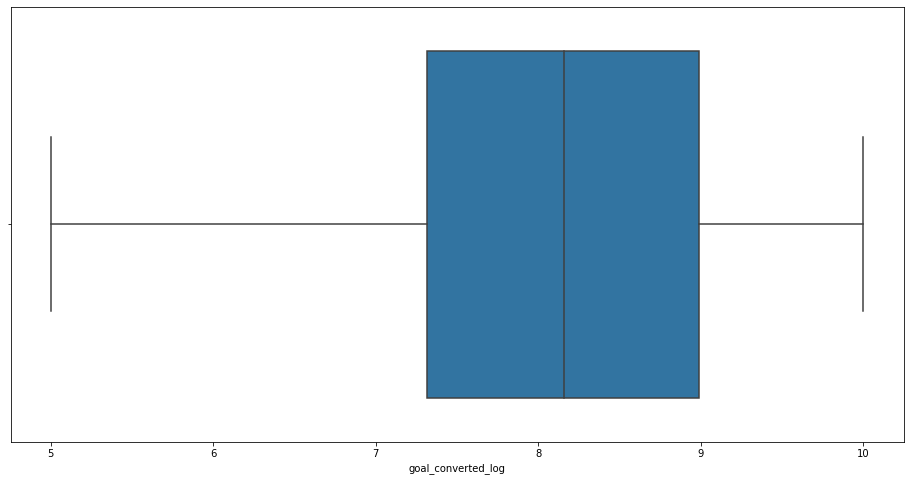

In [44]:
sns.boxplot(df.goal_converted_log)

In [13]:
len(cols)

8